### Imports

In [1]:
import kmapper as km
from kmapper.plotlyviz import *
import sklearn
# DBSCAN from sklearn for clustering algorithms
from sklearn.cluster import DBSCAN
# PCA from sklearn for projection/lens creation
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import RobustScaler,MinMaxScaler
import networkx as nx
import queue
import matplotlib.pyplot as plt

# Plotly and Dash
import plotly.graph_objs as go
import dash_html_components as html
import dash_core_components as dcc
import dash
from ipywidgets import interactive, HBox, VBox, widgets, interact
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pickle,json
from scipy import stats
from statsmodels.stats import multitest

### Functions

In [2]:
def cluster_fun(X, DBSCAN_EPSILON = 20, DBSCAN_MIN_SAMPLES = 1, N_CUBES = [7,7], PERC_OVERLAP = [.5,.5]):
    """

    """
    
    
#     keys = list(dict_df.keys())
#     print(keys)
#     X = dict_df.get(keys[0])
    # Killians interpolation naming for important columns
    kill = ["PREDICTED_WDP", "PREDICTED_SECCHI", "PREDICTED_TEMP", "PREDICTED_DO", 
           "PREDICTED_TURB","PREDICTED_COND", "PREDICTED_VEL", "PREDICTED_TP", 
           "PREDICTED_TN", "PREDICTED_SS", "PREDICTED_CHLcal"]
    
    # My interpolation naming for important columns
    my = ['PredictedTN','PredictedTP','TEMP','DO','TURB','COND','PredictedVEL','SS','WDP','CHLcal','SECCHI']
    nocond = ['PredictedTN','PredictedTP','TEMP','DO','TURB','PredictedVEL','SS','WDP','CHLcal','SECCHI']

    X = X[nocond]
    
    
    if X.shape[0]<DBSCAN_MIN_SAMPLES:
        #print(X)
        print("Not enough data to cluster in ", keys, "_size = ", X.shape[0])
        print("DBSCAN_MIN_SAMPLES", DBSCAN_MIN_SAMPLES)
        return([DBSCAN_MIN_SAMPLES, X.shape[0]])
    
    
    db = DBSCAN(eps=20, min_samples=2).fit(X)
    # Number of clusters in labels, ignoring noise if present.
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    return(db)

    
    
def mapper_pca_func(X,variables,color_variables=None,color_function_name="Distance to xmin", 
                    DBSCAN_EPSILON = 20, DBSCAN_MIN_SAMPLES = 1, N_CUBES = [125,125], PERC_OVERLAP = .4, num_pca=2,no_visual=False,
                    subfolder = "",title = "",verbosity = 0,gradient_colorscaling=None):
    """
    str(df_stratum_season_time_dict_list[1].keys())
    """
    
    # 
#     keys = list(dict_df.keys())
#     print(keys)
#     X = dict_df.get(keys[0])
    kill = ["PREDICTED_WDP", "PREDICTED_SECCHI", "PREDICTED_TEMP", "PREDICTED_DO", 
           "PREDICTED_TURB","PREDICTED_COND", "PREDICTED_VEL", "PREDICTED_TP", 
           "PREDICTED_TN", "PREDICTED_SS", "PREDICTED_CHLcal"]
    
    # My interpolation naming for important columns
    my = ['PredictedTN','PredictedTP','TEMP','DO','TURB','COND','PredictedVEL','SS','WDP','CHLcal','SECCHI']
    nocond = ['PredictedTN','PredictedTP','TEMP','DO','TURB','PredictedVEL','SS','WDP','CHLcal','SECCHI']

    X = X[variables]
    
    X.reset_index(drop=True,inplace = True)
    
    var_to_index = {variables[i] : i for i in range(len(variables))}
    projected_vars = variables
    projected_var_indices = [var_to_index[var] for var in projected_vars]
    
    if verbosity>0:
        print("X.shape: ",X.shape[0])
    

    # defining clustering and kmapper parameters
    
    # create instance of clustering alg
    cluster_alg = sklearn.cluster.DBSCAN(eps=DBSCAN_EPSILON, min_samples=DBSCAN_MIN_SAMPLES, metric='euclidean')

    # Instantiate kepler mapper object
    mapper = km.KeplerMapper(verbose=0)
    
    X_scaled = RobustScaler().fit_transform(X)
    
    # defining filter function as projection on to the first 2 component axis
    pca = PCA(n_components=num_pca)
    lens = pca.fit_transform(X_scaled)
    if(verbosity>0):
        print("Variance explained: ",pca.explained_variance_ratio_)
    
    # Project data onto the ones we want to display
    summary_variable = mapper.project(np.array(X),projection = projected_var_indices, scaler=None)
    
    # Generate the simplicial complex
    scomplex = mapper.map(lens, X_scaled, cover=km.Cover(n_cubes=N_CUBES, perc_overlap=PERC_OVERLAP), clusterer=cluster_alg,remove_duplicate_nodes=True)  

    if no_visual:
        return scomplex,X,X_scaled

    pl_brewer = [[0.0, '#006837'],
             [0.1, '#1a9850'],
             [0.2, '#66bd63'],
             [0.3, '#a6d96a'],
             [0.4, '#d9ef8b'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]

    if not color_variables:
        color_values = lens [:,0] - lens[:,0].min()
        
    else:
        
        if not gradient_colorscaling:
            # Do Caseys color scaling
            color_values = []
            for index,row in X.iterrows():
                color_values.append(get_color_vals(index,X,scomplex,color_variables))
        
        else:
            # Do amber and alaina's color scaling
            print('hi')
            

    
    
    my_colorscale = pl_brewer
    
    kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                     color_values = color_values,  
                                                                     color_function_name=color_variables, 
                                                                     colorscale=my_colorscale)

    bgcolor = 'rgba(10,10,10, 0.9)'
    # y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey

    plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale, 
                                     factor_size=2.5, edge_linewidth=0.5)
    
    plot_title = title + str(DBSCAN_EPSILON) + str(DBSCAN_EPSILON) + ', MIN_SAMPLES ' + str(DBSCAN_MIN_SAMPLES)
    
#     # plot_title = 'Pool 13, Summer 1993-1999; Epsilon ' + str(DBSCAN_EPSILON) + ', MIN_SAMPLES ' + str(DBSCAN_MIN_SAMPLES) 
#     layout = plot_layout(title=plot_title,  
#                          width=620, height=570,
#                          annotation_text=get_kmgraph_meta(mapper_summary),  
#                          bgcolor=bgcolor)
    
#     # FigureWidget is responsible for event listeners

# #     fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
# #     fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor)
# #     fw_summary = summary_fig(mapper_summary, height=300)

#     dashboard = hovering_widgets(kmgraph, 
#                                  fw_graph, 
#                                  bgcolor=bgcolor, 
#                                  member_textbox_width=600)

    # DESIRED FILE PATH, CHANGE TO FIT YOUR LOCAL MACHINE
    directory_path = r"Mapper outputs"
    
    #Update the fw_graph colorbar, setting its title:
    #fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'
    html_output_path = directory_path + "\\"+ subfolder + title + 'PCA_'+str(num_pca) + 'all_var_' + 'Eps_' + str(DBSCAN_EPSILON) +'MinS_' + str(DBSCAN_MIN_SAMPLES) + 'NCUBES_' + str(N_CUBES) + 'PEROvLp_' + str(PERC_OVERLAP) + '.html'
    html_output_path = html_output_path.replace(":","_")
    mapper.visualize(scomplex, path_html=html_output_path, color_values=color_values, color_function_name=color_function_name,lens=summary_variable,lens_names=projected_vars)
    return scomplex, X, X_scaled,mapper_summary


def getSubdf(scomplex, shape, df):
    """
    Returns the part of the data frame from the particular shape in the simplicial complex.
    params:
    scomplex: the entire simplicial complex
    shape: the particular shape being inspected (within the simplicial complex) list of node names
    df: the entire data frame
    
    Description:
    1. Get all the nodes from the particular simplicial complex. 
    2. Generate the indices we care about from the particular shape. To do this, we read each node and append it's 
    indices to a list. Then, we convert the list to a set and then back to a list to eliminate duplicates.
    3. Return the dataframe with only those indices.
    """
    nodes = scomplex.get('nodes')
    indices = []
    npShape = np.array(shape).flatten()
    for node in npShape:
        indices.append(nodes.get(node))
    indices = list(set([item for sublist in indices for item in sublist]))
    subdf = df.loc[indices]
    return subdf

def shapeDataSummary(scomplex, shape, df, variables, verbose = False):
    """
    Generates summary statistics of the given variables for a given shape in the simplicial.
    params:
    scomplex: the entire simplicial complex
    shape: the particular shape being inspected (within the simplicial complex) at this function call.
    df: the entire dataframe
    variables: the variables of interest
    verbose: Determines if the function will print out extra information. False by default
    
    Description:
    1. Create an empty result dataframe to store the summary statistics.
    2. Get the sub dataframe (see getSubdf) for the particular shape
    3. For each variable we are analzying, generate summary statistics from the sub dataframe and place them
    inside the result dataframe.
    4. Return the result dataframe
    
    NOTE: this only creates summaries for one particular shape. In executing this method, it is done for each shape 
    outside of the function.
    
    """
    result = pd.DataFrame()
    if verbose == True:
        print("Obtaining sub dataframe for: ", shape)
        print("The number of nodes in this shape is: ", len(shape))
    subdf = getSubdf(scomplex, shape, df)
    if verbose == True:
        print("The number of datapoints in this shape is: ", subdf.shape[0])
    for var in variables:
        result[var] = subdf[var].describe()
    return result
    
    

def adjacent(v, scomplex):
    """
    Determines the nodes adjacent to a given vertex
    
    params:
    v: vertex
    scomlex: the entire simplicial complex
    
    Description:
    Determines the nodes that are adjacent to a given vertex.
    """
    
    simplices = scomplex.get('simplices')
    edges = [item for item in simplices if len(item) == 2]
    result = []
    for edge in edges:
        if v in edge:
            for item in edge:
                if item != v:
                    result.append(item)
    return result

def bfs(node, scomplex):
    """
    Conducts a breadth first search to obtain the entire shape from a given node
    params:
    node: the start node
    scomplex: the entire simplicial complex
    
    Description:
    Preforms a breadth first search to obtain the entire shape for a given start node.
    """
    Q = queue.Queue()
    result = []
    result.append(node)
    Q.put(node)
    while not Q.empty():
        v = Q.get()
        adjacentEdges = adjacent(v, scomplex)
        for edge in adjacentEdges:
            if edge not in result:
                result.append(edge)
                Q.put(edge)
    return result


        
    
def getShapes(scomplex):
    """
    Gets all of the shapes from a given simplicial complex.
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Obtain all the nodes for the entire complex
    2. For each node, preform a breadth first search to obtain everything in that particular shape. 
    If this entire shape has not already been discovered, add it to the set of results. 
    The result item is a set as the order of the shapes does not matter. The resulting shape is a frozenset
    which means items cannot be added or removed once created, and is needed to allow the set object to have other sets within it.
    3. Convert each shape to a list and the result to a list for easier navigation outside of the function.
    4. Return the result
    
    """
    
    nodes = list(scomplex.get('nodes').keys())
    result = set()
    for node in nodes: # currently does more computations than necessary due to going through every node without considering it is already in a shape
        bfsResult = frozenset(bfs(node, scomplex))
        result.add(bfsResult)
    result = [list(x) for x in result]
    # Sort the list depending on what is decided: nodes or indices. Currently doing it by number of nodes
    result.sort(key = len, reverse = True)
    
    
    
    return result

def nodeDataSummary(node, scomplex, variables,df):
    """
    Returns a data summary of a particular node
    params:
    node: node in question
    scomplex: The entire simplicial complex
    variables: The variables to obtain summaries
    df: the entire dataframe 
    
    description:
    1. Creates a result dataframe
    2. Get all the indices from the node from the simplicial complex
    3. Generate summaries for each variable
    4. Return the result
    """
    result = pd.DataFrame()
    if isinstance(node, list):
        print("Node is a list and thus cannot get summary information: ", node)
        indices = scomplex.get('nodes').get(node[0])
        subdf = df.loc[indices]
        for var in variables:
            result[var] = subdf[var].describe()
        return result
    
        
    indices = scomplex.get('nodes').get(node)
    subdf = df.loc[indices]
    for var in variables:
        result[var] = subdf[var].describe()
    return result
    
    
def condenseShape(shape, scomplex):
    """
    
    params:
    shape: a shape of two nodes. must be 2
    scomplex: the entire simplicial complex
    
    description:
    gets the two nodes a and b
    gets the indices for a and b (what is inside the nodes)
    if a \subseteq b, return b
    elif b \subseteq a, return a 
    else return shape 
    
    """
    nodes = scomplex.get('nodes')
    a = shape[0]
    b = shape[1]
    aIndices = set(nodes.get(a))
    bIndices = set(nodes.get(b))
    
    if aIndices.issubset(bIndices):
        return b
    elif bIndices.issubset(aIndices):
        return a
    else:
        return shape

def clean_getShapes(scomplex):
    """
    Condenses 1-simplices down to 0-simplices when each node 
    is a subset of the other 
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Get all the shapes from the original getShapes function
    2. For shapes that of length 2, if one is a subset of the other, return the larger of the two
        Otherwise, do nothing
    3. return the clean Shapes list 
    
    """
    shapes = getShapes(scomplex)
    cleanShapes = []
    for shape in shapes:
        if len(shape) == 2:
            shape = condenseShape(shape, scomplex)
            cleanShapes.append([shape])
        else:
            cleanShapes.append(shape)
    return cleanShapes


def getBoxplots(subdf, shape, key,filePath):
    """
    Generates box plots for 10 of the 11 continuous variables
    NOTE: CONDUCTIVITY IS NOT INCLUDED
    
    params:
    subdf: the sub dataframe of the particular shape
    shape: the shape in question
    key: what strata year season combo we are looking at 
    filePath: the output file path for all the box plots 
    
    description:
    clears the current plot 
    generates the sub dataframes for the respective variables.
    the reason they are grouped is based upon the numerical outputs for making the boxplots readable
    create a box plot, and then save it based upon the file path
    clear the plot
    repeat for the second set of variables
    """
    plt.clf()
    varDf1 = subdf[["PREDICTED_SS","PREDICTED_TURB","PREDICTED_TEMP","PREDICTED_CHLcal","PREDICTED_SECCHI"]]
    varDf2 = subdf[["PREDICTED_TP","PREDICTED_TN","PREDICTED_DO","PREDICTED_VEL","PREDICTED_WDP"]]
    plot1 = varDf1.boxplot(rot = 45)
    plt.savefig(filePath + "\\" + key +"_" + str(shape)  + "_SS_TURB_CHLcal"  + ".png")
    plt.clf()
    plot2 = varDf2.boxplot(rot = 45)
    plt.savefig(filePath + "\\" + key +"_" + str(shape)  + "_" + "TP_TN_VEL_etc" + ".png")
    return plot1, plot2

def determineOverlap(scomplex, shape, verbose = True):
    """
    Determines the overlap within a shape. 
    
    For each node, find it's neighbors, and generate the intersection, and saving the result without
    duplicates through utlizing the set functionality of python.
    
    params:
    scomplex: the entire simplicial complex in question
    shapes: all the shapes
    verbose: see prinout as the code works
    """
    
    result = set()
    if verbose:
        print("Shape: ", shape)
    nodes = scomplex.get('nodes')
    for node in shape:
        # currently, this displays a lot of repeats. 
        A = set(nodes.get(node))
        if verbose:
            print("Node: " , node  , " | Indices: ",A)
        B = adjacent(node, scomplex)
        if verbose:
            print("Adjacent nodes: ",B)
        for b in B:
            bSet = set(nodes.get(b))
            name = str(node) + " -> " + str(b) +": "
            intersection = set(A.intersection(bSet))
            intersection.add(name)
            intersection = frozenset(intersection)
            result.add(intersection)
            if verbose:
                print("Node: ", b, " | Indices: ", bSet)
                print("Overlap is: ", A.intersection(bSet))
    return result


def k_nearest_neighbors(df, neigh, point, k):
    return neigh.kneighbors([list(df.loc[point])], k)[0].flatten()
    
def calculate_density(scomplex, node, df, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df)
    knn = 0
    n = len(scomplex['nodes'][node])
    for point in scomplex['nodes'][node]:
        distances = k_nearest_neighbors(df, neigh, point, k)
        knn += (sum(distances) / k)
    density = knn / (n*n)
    return (1.0 / density)

def generate_graph(scomplex, shape):
    dg = generate_nodes(scomplex, shape)
    dg = generate_edges(scomplex, shape, dg)
    return dg

def generate_nodes(scomplex, shape):
    dg = nx.DiGraph()
    dg.add_nodes_from(shape)
    return dg

def generate_edges(scomplex, shape, dg):
    for node in shape:
        if node in scomplex['links']:
            for adjacent_node in scomplex['links'][node]:
                if scomplex['density'][node] < scomplex['density'][adjacent_node]:
                    dg.add_edge(node, adjacent_node)
                else:
                    dg.add_edge(adjacent_node, node)
    return dg

def get_local_maxima(dg):
    maxima = []
    for node in list(dg.nodes):
        succ = dict(nx.bfs_successors(dg, source=node))
        if not succ[node]:
            maxima.append(node)
    return maxima

def draw_graph(scomplex, filepath, with_labels=False):
    colors = ['#66664D', '#991AFF', '#E666FF', '#4DB3FF', '#1AB399',
		  '#E666B3', '#33991A', '#CC9999', '#B3B31A', '#00E680', 
		  '#4D8066', '#809980', '#E6FF80', '#1AFF33', '#999933',
		  '#FF3380', '#CCCC00', '#66E64D', '#4D80CC', '#9900B3', 
		  '#E64D66', '#4DB380', '#FF4D4D', '#99E6E6', '#6666FF']
    colors_dict = {scomplex['maxima'][i] : colors[i] for i in range(len(scomplex['maxima']))}
    transition_color = '#ffff00'
    color_map = []
    scomplex['states'] = {scomplex['maxima'][i] : [] for i in range(len(scomplex['maxima']))}
    
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(111)
    ax.set_title('Graph - Shapes', fontsize=72)
    
    for node in scomplex['graph']:
        distDict = {scomplex['maxima'][i] : graph_distance(scomplex['graph'], node, scomplex['maxima'][i])
                    for i in range(len(scomplex['maxima']))}
        minDist = min(distDict.values())
        states = [maxima if distDict[maxima] == minDist else None for maxima in scomplex['maxima']]
        states = list(filter(None, states))
        
        for state in states:
            scomplex['states'][state].append(node)
        
        if len(states) > 1:
            color_map.append(transition_color)
        else:
            color_map.append(colors_dict[states[0]])

    
    nx.draw_kamada_kawai(scomplex['graph'], with_labels=with_labels, node_color=color_map)
    plt.tight_layout()
    plt.savefig(filepath, format="PNG")
    plt.show()

def graph_distance(dg, source, target):
    if nx.has_path(dg, source, target):
        return len(nx.shortest_path(dg, source, target))
    return float('inf')


def getNodesfromIndex(scomplex, index):
    """
    docstring to write later
    """
    result = set()
    nodes = scomplex['nodes']
    nodesList = list(scomplex['nodes'].keys())
    for node in nodesList:
        if index in nodes[node]:
            result.add(node)
    
    return list(result)


def get_color_vals(index,df,scomplex,variables):
    """
    Gets the new color value assignment for this row
    """
    relevant_nodes = getNodesfromIndex(scomplex,index)
    
    #print(relevant_nodes)
    
    relevant_df = getSubdf(scomplex,relevant_nodes,df)
    
    colorvals = relevant_df[variables].mean()
    
    return list(colorvals)


def output_density_graph(scomplex,X_scaled,title = "random_title"+str(int(100*round(np.random.rand(),3))),verbosity = 0):
    '''
    Does the work for outputting the number of states and directed graph
    '''
    
    scomplex["density"] = {}

    largestShape = np.array(clean_getShapes(scomplex)[0]).flatten()
    if verbosity>0:
        print("Largest shape is: ",largestShape, "\n")
    Y = pd.DataFrame(X_scaled)
    largestShape_df = getSubdf(scomplex,largestShape,Y)
    k = int(round(X_scaled.shape[0]/10,0))
    for node_name in largestShape:
        if verbosity>0:
            print("Node Name: ",node_name)
        scomplex["density"][node_name] = calculate_density(scomplex,node_name,largestShape_df,k)
        
        
    scomplex['graph'] = generate_graph(scomplex,largestShape)
    scomplex['maxima'] = get_local_maxima(scomplex['graph'])
    print("Maximum: ", scomplex['maxima'])
    print("Number of states: ",len(scomplex['maxima']))
    filepath = r"Mapper outputs\Directed Graphs" + "\\" +title+".png"
    draw_graph(scomplex,filepath,with_labels=False)
    
    return scomplex

print("Functions loaded")

Functions loaded


### Load data

Run this cell to use Ambers Random Forrest interpolated dataset

In [4]:
continuous = ['TN','TP','TEMP','DO','TURB','COND','VEL','SS','WDP','CHLcal','SECCHI']
nocond = ['TN','TP','TEMP','DO','TURB','VEL','SS','WDP','CHLcal','SECCHI']

seasons = {3:"SPRING",4:"SPRING",5:"SPRING",6:"SUMMER",7:"SUMMER",8:"SUMMER",9:"FALL",10:"FALL",11:"FALL",12:"WINTER",1:"WINTER",2:"WINTER"}

water_data = pd.read_csv(r"..\..\LTRM data\RF interpolation\water_combinedcols.csv")

print("Now adding a month column")
water_data["MONTH"] = pd.DatetimeIndex(water_data["DATE"]).month
print("Now adding a season column")
water_data["SEASON"] = water_data["MONTH"]
water_data = water_data.replace({"SEASON":seasons})
print("Filtering by pool")
water_data = water_data[water_data["FLDNUM"]=="Jackson, MO"].reset_index(drop=True)
print(water_data.columns)
#water_data.dropna(axis=0, how='any', thresh=None, subset=nocond, inplace=True)
water_data.shape

Now adding a month column
Now adding a season column
Filtering by pool
Index(['SHEETBAR', 'DATE', 'LATITUDE', 'LONGITUDE', 'FLDNUM', 'STRATUM',
       'LOCATCD', 'TN', 'TP', 'TEMP', 'DO', 'TURB', 'COND', 'VEL', 'SS', 'WDP',
       'CHLcal', 'SECCHI', 'YEAR', 'SEASON', 'MONTH'],
      dtype='object')


(14200, 21)

In [8]:
d_data = pd.read_csv(r"..\..\LTRM data\water_data_qfneg.csv")
d_data["FLDNUM"].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [9]:
d_data[d_data["FLDNUM"]==5].shape

(14200, 18)

Test n_cubes, perc overlap for the following heuristics:
1. No more than 10% of data in a node
2. Persistence of shape
3. Don't lose more than 10% of entire data


For ALL DATA:
eps = 1.2
min samples = 20
ncubes = [125,125]
perc_overlap = 0.4

For Open River:
eps = 1
min samples = 20
ncubes = [55,17]
perc_overlap = 0.4

with Open river parameters, the largest node contains 8 percent of the entire data and 89% of the data is retained.


In [115]:
num_rows = water_data.shape[0]
#perc_overlap_list = [0.15,0.25,0.35,0.45,0.55]
#n_cubes_list = [[30,int(30//3.27)],[50,int(50//3.27)],[70,int(70//3.27)],[90,int(90//3.27)],[110,int(110//3.27)],[130,int(130//3.27)]]

min_samples = 20
epsilon = 1

for perc_overlap in [0.5]:
    for n_cubes in [[70,21]]:
        strnum = str(int(perc_overlap*100))
        subfolder = "Shape persistence\\perc_"+strnum+"\\"
        scomplex,X,X_scaled,mapper_summary = mapper_pca_func(water_data,nocond,color_variable="CHLcal",color_function_name = "Chlorophyll",N_CUBES=n_cubes,
                       PERC_OVERLAP = perc_overlap,DBSCAN_MIN_SAMPLES = min_samples,DBSCAN_EPSILON=epsilon,num_pca = 2,
                       subfolder = subfolder)
        
        max_size = max([len(scomplex['nodes'][node]) for node in scomplex['nodes']])
        samples_used = mapper_summary['n_unique']
        
        
        print("---------")
        print(str(perc_overlap)+" "+str(n_cubes))
        print("Largest node is "+str(round(max_size/num_rows,4))+" of entire data")
        print("Retained "+str(round(samples_used/num_rows,4))+" of entire data")
         

---------
0.15 [30, 9]
Largest node is 0.1217 of entire data
Retained 0.896 of entire data
---------
0.15 [50, 15]
Largest node is 0.0637 of entire data
Retained 0.8333 of entire data
---------
0.15 [70, 21]
Largest node is 0.0344 of entire data
Retained 0.7393 of entire data
---------
0.15 [90, 27]
Largest node is 0.0239 of entire data
Retained 0.6636 of entire data
---------
0.15 [110, 33]
Largest node is 0.018 of entire data
Retained 0.555 of entire data
---------
0.15 [130, 39]
Largest node is 0.0126 of entire data
Retained 0.4409 of entire data
---------
0.25 [30, 9]
Largest node is 0.1459 of entire data
Retained 0.9129 of entire data
---------
0.25 [50, 15]
Largest node is 0.0767 of entire data
Retained 0.868 of entire data
---------
0.25 [70, 21]
Largest node is 0.0423 of entire data
Retained 0.8036 of entire data
---------
0.25 [90, 27]
Largest node is 0.0282 of entire data
Retained 0.7287 of entire data
---------
0.25 [110, 33]
Largest node is 0.0221 of entire data
Retained 0.

It seems as ncubes increases with constant percent overlap, more data is lost. As percent overlap increases with constanc ncubes, the percent in the amount of data in the largest node increases

The 3 candidates for parameters out of sequence

In [207]:
color_variables = nocond
title = "Open river"
scomplex45, X45, X_scaled45,mapper_summary45 = mapper_pca_func(water_data,nocond,color_variables = color_variables,
                              color_function_name = color_variables,N_CUBES=[70,21],PERC_OVERLAP=0.45,DBSCAN_MIN_SAMPLES = 20,
                                DBSCAN_EPSILON=1,num_pca=2,title=title,no_visual=False)

scomplex25, X25, X_scaled25,mapper_summary25 = mapper_pca_func(water_data,nocond,color_variables = color_variables,
                              color_function_name = color_variables,N_CUBES=[50,15],PERC_OVERLAP=0.25,DBSCAN_MIN_SAMPLES = 20,
                                DBSCAN_EPSILON=1,num_pca=2,title=title,no_visual=False)

scomplex35, X35, X_scaled35,mapper_summary35 = mapper_pca_func(water_data,nocond,color_variables = color_variables,
                              color_function_name = color_variables,N_CUBES=[50,15],PERC_OVERLAP=0.35,DBSCAN_MIN_SAMPLES = 20,
                                DBSCAN_EPSILON=1,num_pca=2,title=title,no_visual=False)

Messing with more parameters

In [223]:
num_rows = water_data.shape[0]
color_variables = nocond
title = "Open river experiment3"
perc_overlap = 0.4
n_cubes = [55,17]


scomplex, X, X_scaled,mapper_summary = mapper_pca_func(water_data,nocond,color_variables = color_variables,
                              color_function_name = color_variables,N_CUBES=n_cubes,PERC_OVERLAP=perc_overlap,DBSCAN_MIN_SAMPLES = 20,
                                DBSCAN_EPSILON=1,num_pca=2,title=title,no_visual=False)

max_size = max([len(scomplex['nodes'][node]) for node in scomplex['nodes']])
samples_used = mapper_summary['n_unique']
        
print("---------")
print(str(perc_overlap)+" "+str(n_cubes))
print("Largest node is "+str(round(max_size/num_rows,4))+" of entire data")
print("Retained "+str(round(samples_used/num_rows,4))+" of entire data")

---------
0.4 [55, 17]
Largest node is 0.0799 of entire data
Retained 0.8914 of entire data


Take a look at how many states are in each output

Maximum:  ['cube73_cluster0', 'cube113_cluster0', 'cube160_cluster0', 'cube291_cluster0', 'cube176_cluster0', 'cube120_cluster0']
Number of states:  6


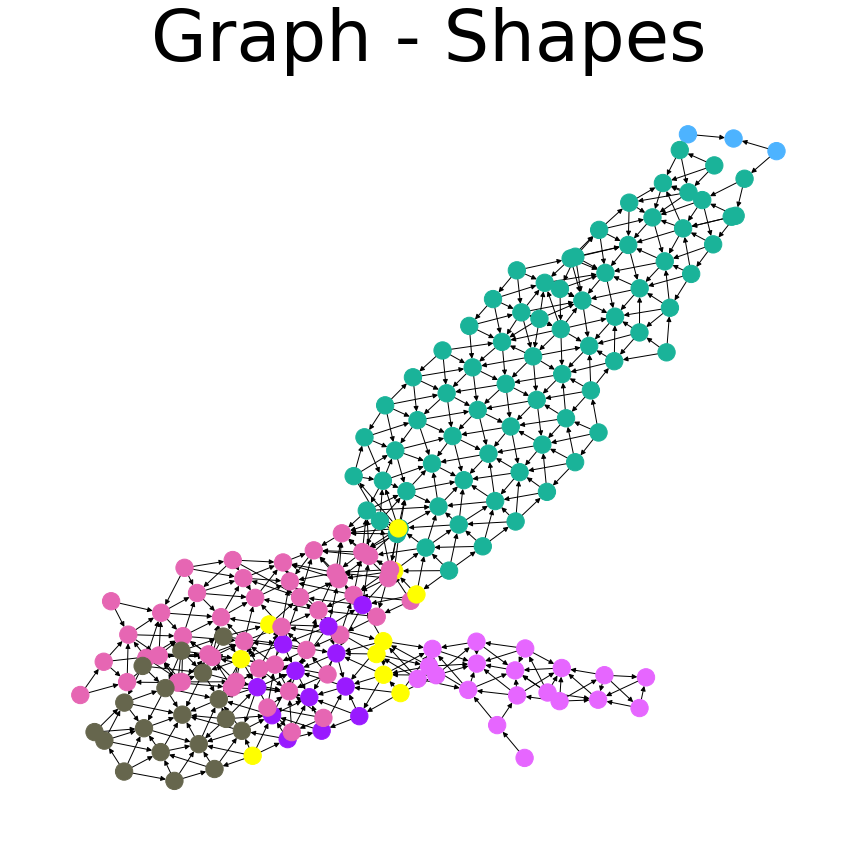

{'nodes': {'cube47_cluster0': [2075,
   2077,
   2974,
   2078,
   2079,
   2081,
   2980,
   2470,
   2983,
   2220,
   2476,
   2478,
   817,
   818,
   2481,
   2995,
   1236,
   1240,
   1243,
   2022,
   4465],
  'cube50_cluster0': [3072,
   3073,
   3074,
   3075,
   3076,
   3135,
   3137,
   3142,
   3146,
   3047,
   3048,
   3049,
   3050,
   3053,
   3054,
   10734,
   3056,
   3057,
   3058,
   3059,
   3060,
   3061,
   3065,
   3066,
   3068,
   3069,
   3070,
   3071],
  'cube51_cluster0': [1304,
   1305,
   1306,
   1307,
   1308,
   2585,
   1315,
   1316,
   1317,
   5542,
   10793,
   5546,
   10794,
   9013,
   9015,
   9018,
   9027,
   9045,
   2129,
   9048,
   1365,
   1366,
   1367,
   1368,
   89,
   1369,
   91,
   1370,
   93,
   94,
   95,
   96,
   97,
   1371,
   9051,
   9053,
   9056,
   10732,
   9070,
   9071,
   9072,
   9073,
   9074,
   9075],
  'cube52_cluster0': [7177,
   7180,
   7182,
   7185,
   7186,
   7187,
   7188,
   7189,
   7190,
   719

In [214]:
title = "perc45-ncubes70-21"
scomplex = output_density_graph(scomplex45,X_scaled45,title=title)

Maximum:  ['cube39_cluster0', 'cube62_cluster0', 'cube57_cluster0', 'cube86_cluster0', 'cube81_cluster0']
Number of states:  5


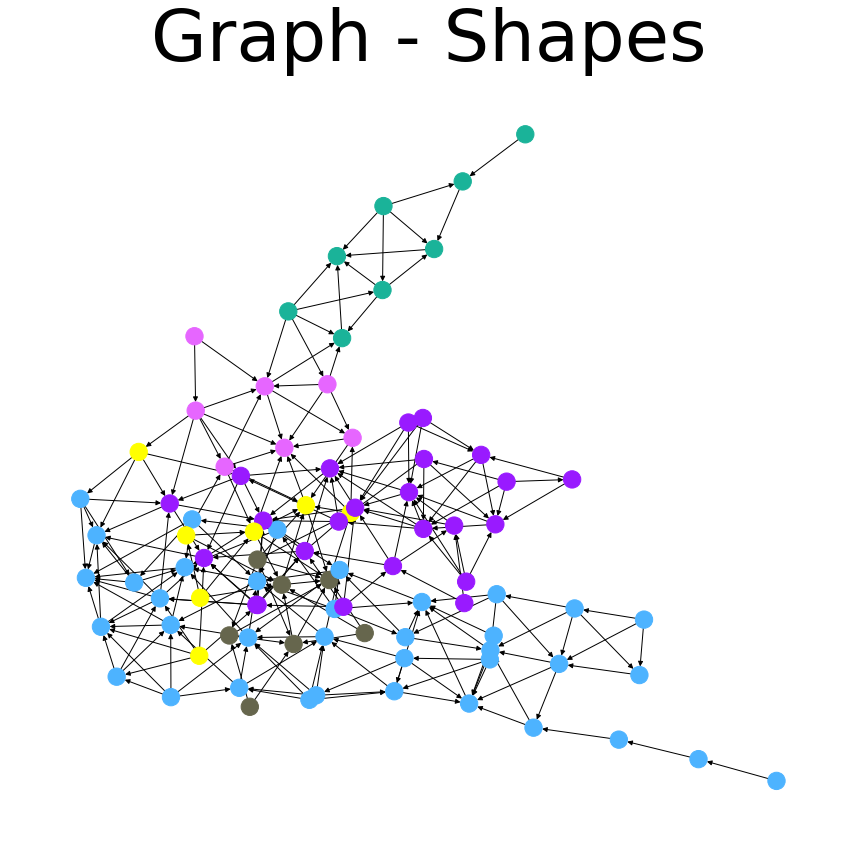

{'nodes': {'cube23_cluster0': [7175,
   7186,
   7187,
   1307,
   1308,
   1315,
   5546,
   1365,
   1366,
   1367,
   1368,
   1369,
   1370,
   1371,
   10732,
   9070,
   9071,
   9072,
   9073,
   9074,
   9075,
   9076,
   9077],
  'cube28_cluster0': [2977,
   8069,
   2978,
   2979,
   783,
   784,
   3600,
   3870,
   2981,
   2074,
   2972,
   2973,
   2974,
   2982,
   2976,
   2081,
   2466,
   2467,
   804,
   805,
   806,
   2469,
   2470,
   2471,
   2218,
   555,
   2219,
   2221,
   2472,
   2223,
   2473,
   2474,
   818,
   819,
   820,
   2476,
   2481,
   2482,
   2992,
   2993,
   2994,
   3891,
   2475,
   12341,
   4928,
   3880,
   3881,
   1224,
   1225,
   1226,
   1227,
   1228,
   1229,
   1230,
   3882,
   1232,
   471,
   474,
   4826,
   4827,
   3889,
   2547,
   501,
   2549],
  'cube30_cluster0': [3072,
   3073,
   3074,
   3075,
   3076,
   10792,
   10793,
   10794,
   10795,
   10796,
   10797,
   10798,
   10799,
   10801,
   3135,
   3137,
   313

In [215]:
title = "perc25-ncubes50-15"
scomplex = output_density_graph(scomplex25,X_scaled25,title=title)

Maximum:  ['cube40_cluster0', 'cube152_cluster0', 'cube64_cluster0', 'cube84_cluster0', 'cube89_cluster0']
Number of states:  5


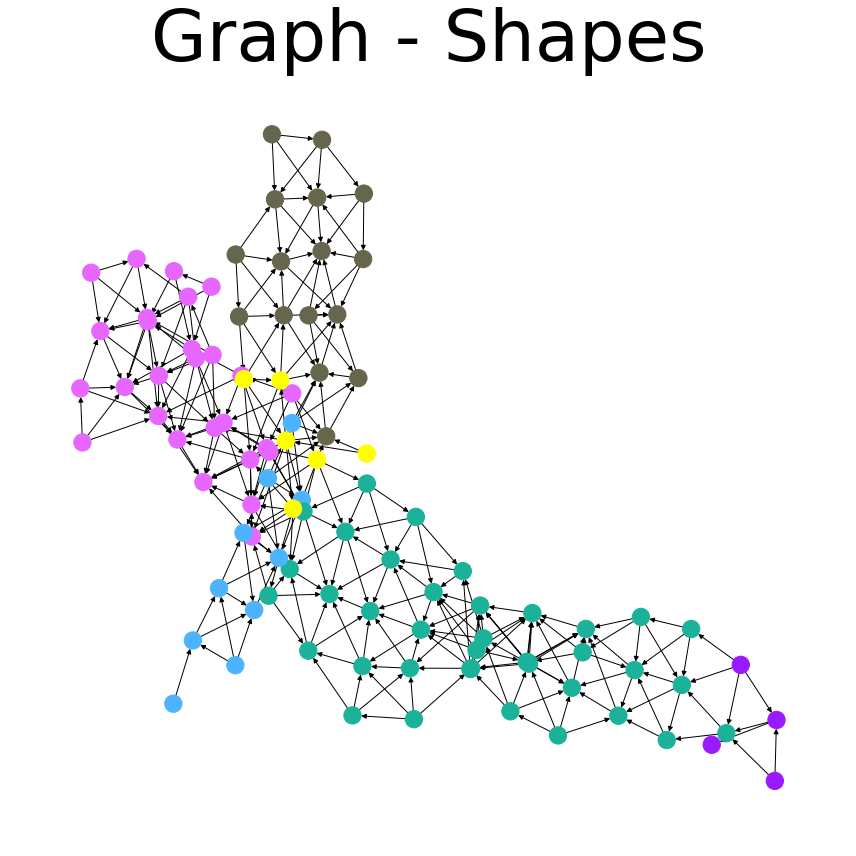

{'nodes': {'cube23_cluster0': [1304,
   1307,
   1308,
   1315,
   1365,
   1366,
   1367,
   1368,
   1369,
   1370,
   91,
   1371,
   96,
   97,
   9070,
   9071,
   9072,
   9073,
   9075,
   9076],
  'cube24_cluster0': [7175,
   7182,
   7185,
   7186,
   7187,
   7188,
   1304,
   1307,
   1308,
   1315,
   5546,
   7121,
   1365,
   1366,
   1367,
   1368,
   1369,
   1370,
   91,
   1371,
   9051,
   96,
   10732,
   9070,
   9071,
   9072,
   9073,
   9074,
   9075,
   9076,
   9077],
  'cube28_cluster0': [8069,
   2970,
   2971,
   2972,
   2973,
   2974,
   3870,
   2977,
   2978,
   2979,
   2980,
   2982,
   557,
   558,
   2992,
   2993,
   2994,
   2996,
   565,
   12341,
   4927,
   1236,
   1237,
   1238,
   1240,
   1241,
   1242,
   2938,
   2939],
  'cube29_cluster0': [3600,
   2074,
   2081,
   555,
   12341,
   3662,
   2475,
   2218,
   2219,
   2221,
   2223,
   1218,
   1224,
   1225,
   1226,
   1227,
   1228,
   1229,
   1230,
   1232,
   1240,
   1242,
   48

In [216]:
title = "perc35-ncubes50-15"
scomplex = output_density_graph(scomplex35,X_scaled35,title=title)

Mapper output of summer data

In [44]:
water_data_summer = water_data[water_data["SEASON"]=="SUMMER"]
print(water_data_summer.shape)
title = "Open_river_summer_pca2_ncubes(60,60),perc40,min5,eps10"
scomplex, X = mapper_pca_func(water_data_summer,title,nocond,color_variable = "TURB",
                              color_function_name = "Turbidity",N_CUBES=[60,60],PERC_OVERLAP=0.4,DBSCAN_MIN_SAMPLES = 5,DBSCAN_EPSILON=10,num_pca=2)

(3325, 21)
X.shape:  3325
Variance explained:  [0.97156121 0.01705704]


### Playing with colors and kmapper objects

### Density state definitions

In [19]:
### Creating three main time spans and two overlapping time spans,
### a total of five time spans

# defining different time periods
# first decade
time_dec1 = [1993, 1994, 1995, 1997, 1998, 1999, 2000]
# second decade
time_dec2 = [2001, 2002,2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
# third decade
time_dec3 = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
# overlap time periods for continuity
time_overlap1 = [1998, 1999, 2000, 2001, 2002,2003, 2004]
time_overlap2 = [2010, 2011, 2012, 2013, 2014, 2015, 2016]
time_list = [time_dec1, time_overlap1, time_dec2, time_overlap2, time_dec3]

time_list_names = ['93-00', '98-04', '01-13', '10-16', '14-20']
# The stratums in my pool
stratum_list = [1, 2] #, 4, 5, 6, 7, 9]
# The seasons we are currently looking at
Season_names = ["SUMMER"] #, "SPRING", "FALL", "WINTER"]


df_stratum_season_time_dict = {}
s=""
for i in range(len(time_list)):
    for j in stratum_list:
        for k in Season_names:
            s= "Stratum " + str(j)+ " " + k + " " + time_list_names[i] + ": "
            df_stratum_season_time_dict[s] = predicted_df[(predicted_df['YEAR'].isin(time_list[i])) &
                                                             (predicted_df['STRATUM'].isin([j])) & 
                                                             (predicted_df['SEASON'].isin([k]))]
            s=""
print(len(df_stratum_season_time_dict))

10


In [20]:
for key in df_stratum_season_time_dict:
    print(key)

Stratum 1 SUMMER 93-00: 
Stratum 2 SUMMER 93-00: 
Stratum 1 SUMMER 98-04: 
Stratum 2 SUMMER 98-04: 
Stratum 1 SUMMER 01-13: 
Stratum 2 SUMMER 01-13: 
Stratum 1 SUMMER 10-16: 
Stratum 2 SUMMER 10-16: 
Stratum 1 SUMMER 14-20: 
Stratum 2 SUMMER 14-20: 


In [35]:
len(mapper_pca_output_dict)

90

Saving all outputs to json save scomplices and data

In [36]:

jsonFile = json.dumps(mapper_output_dict)
f = open("All_graphs.json","w")
pickle = pickle.dump(mapper_output_df,path)
f.write(jsonFile)
f.close()

Load mapper data

In [37]:
jsonFilePath = r"All_graphs.json"
jsonFile = open(jsonFilePath,"r")
data = json.load(jsonFile)
jsonFile.close()

In [38]:
len(data.keys())

90

Pick one output to analyze

In [43]:
#key = list(data.keys())[0]
key = "Stratum 2 SUMMER 01-13: ncubes_10_overlap_0.45"
print(key)
output = data[key]
output.keys()

Stratum 2 SUMMER 01-13: ncubes_10_overlap_0.45


dict_keys(['nodes', 'links', 'simplices', 'meta_data', 'meta_nodes'])

Function to return a nested list of connected components

In [127]:
def connected_components(output):
    simplices = output.get("simplices")
    # Pick out the edges
    pairs = [item for item in simplices if len(item)==2]
    # Pick out all nodes
    nodes = output.get("nodes").keys()
    # Unpacks the list of lists to get every node that is connected to at least one other node with an edge
    connected_nodes = [node for sublist in edges for node in sublist]
    # Pick out the nodes that are its own connected component (not a connected node)
    singles = [[node] for node in nodes if node not in connected_nodes]
    
    # Build connected components
    components = []
    for a, b in pairs:
        for component in components:
            if a in component:
                for i, other_component in enumerate(components):
                    if b in other_component and other_component != component: # a, and b are already in different components: merge
                        component.extend(other_component)
                        components[i:i+1] = []
                        break # we don't have to look for other components for b
                else: # b wasn't found in any other component
                    if b not in component:
                        component.append(b)
                break # we don't have to look for other components for a
            if b in component: # a wasn't in in the component 
                component.append(a)
                break # we don't have to look further
        else: # neither a nor b were found
            components.append([a, b])
            
    # Add the singles into the components
    print("Number of singles:",len(singles))
    components.extend(singles)
    
    # Sort the components by size
    components.sort(reverse = True, key = len)
    
    return components

In [128]:
components = connected_components(output)
len(components)
for component in components:
    print(len(component))

Number of singles: 15


## Analysis by State for Entire Dataset AND Open River

In [4]:
# Load complices
ALL_scaler = pickle.load( open( r"C:\Users\cashe\OneDrive\Documents\GitHub\UMR-TDA-2021\pools_specific_EDA\Open River\Mapper outputs\Entire Data DDF\scaler.p", "rb" ) )
ALL_scomplex = pickle.load( open( r"C:\Users\cashe\OneDrive\Documents\GitHub\UMR-TDA-2021\pools_specific_EDA\Open River\Mapper outputs\Entire Data DDF\scomplex.p", "rb" ) )
ALL_Xscaled = pickle.load( open( r"C:\Users\cashe\OneDrive\Documents\GitHub\UMR-TDA-2021\pools_specific_EDA\Open River\Mapper outputs\Entire Data DDF\X_scaled.p", "rb" ) )
ALL_X = pickle.load( open( r"C:\Users\cashe\OneDrive\Documents\GitHub\UMR-TDA-2021\pools_specific_EDA\Open River\Mapper outputs\Entire Data DDF\X.p", "rb" ) )


OPEN_scaler = pickle.load( open( r"C:\Users\cashe\OneDrive\Documents\GitHub\UMR-TDA-2021\pools_specific_EDA\Open River\Mapper outputs\Open River DDF\scaler.p", "rb" ) )
OPEN_scomplex = pickle.load( open( r"C:\Users\cashe\OneDrive\Documents\GitHub\UMR-TDA-2021\pools_specific_EDA\Open River\Mapper outputs\Open River DDF\scomplex.p", "rb" ) )
OPEN_Xscaled = pickle.load( open( r"C:\Users\cashe\OneDrive\Documents\GitHub\UMR-TDA-2021\pools_specific_EDA\Open River\Mapper outputs\Open River DDF\X_scaled.p", "rb" ) )
OPEN_X = pickle.load( open( r"C:\Users\cashe\OneDrive\Documents\GitHub\UMR-TDA-2021\pools_specific_EDA\Open River\Mapper outputs\Open River DDF\X.p", "rb" ) )

Count the number of points in each state

In [294]:
# ALL output
scomplex = ALL_scomplex
X_scaled = ALL_Xscaled
df = ALL_X

for state in scomplex['maxima']:
    df = getSubdf(scomplex, scomplex['states'][state], X_scaled)
    print("Number of points in "+str(state)+" is ",df.shape[0])


Number of points in cube834_cluster0 is  370
Number of points in cube671_cluster0 is  851
Number of points in cube60_cluster0 is  70830


In [295]:
# OPEN output
scomplex = OPEN_scomplex
X_scaled = OPEN_Xscaled
df = OPEN_X

for state in scomplex['maxima']:
    df = getSubdf(scomplex, scomplex['states'][state], X_scaled)
    print("Number of points in "+str(state)+" is ",df.shape[0])

Number of points in cube192_cluster0 is  69
Number of points in cube105_cluster0 is  845
Number of points in cube80_cluster0 is  4394
Number of points in cube52_cluster0 is  1789
Number of points in cube110_cluster0 is  5375


Boxplots comparing each state

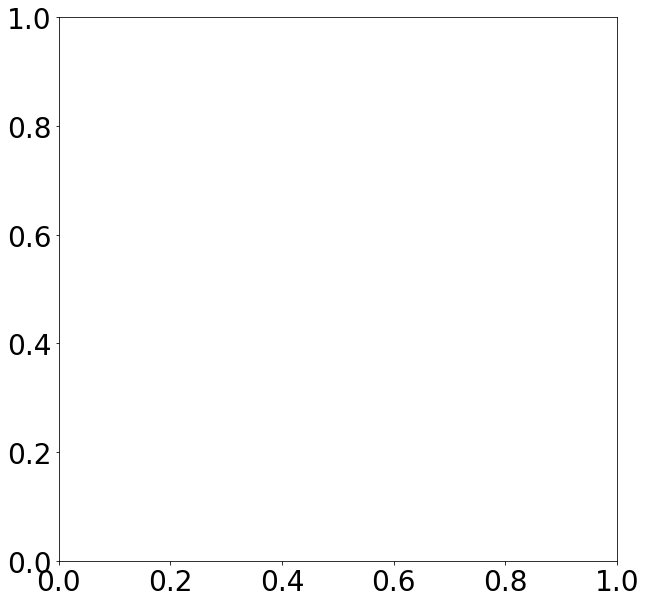

In [13]:
# Change ALL to OPEN to get different results
scaler = ALL_scaler
scomplex = ALL_scomplex
X_scaled = ALL_Xscaled
df = ALL_X

# Important that variables are in this order
variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

#X_minmax = MinMaxScaler().fit_transform(df)

#X_minmaxdf = pd.DataFrame(X_minmax,columns=df.columns)


for state in scomplex['states']:
    df = getSubdf(scomplex, scomplex['states'][state], X_scaled)
    
    df.columns = variables
    
    plot_vars = ["TURB","VEL","DO","SS"]
    
    #df_orig = scaler.inverse_transform(df)
    #df_minmax = pd.DataFrame(MinMaxScaler().fit_transform(df_orig),columns=variables)
    
    # Make a boxplot of the df
    ax = df.boxplot(column=plot_vars,return_type='axes',figsize=(10,10),fontsize=28,rot=45)
    ax.set_ylim(bottom=-2.4,top=8.8)
    
    ax.figure.savefig("Entire Data robust"+str(df.shape[0]))
    plt.cla()

Comparing States by variable

In [27]:
test = getSubdf(scomplex,scomplex['states']['cube60_cluster0'],X_scaled)

In [28]:
test.shape

(70830, 10)

,1,2,3
0,NaN,None,None
1,NaN,None,None
2,NaN,None,None
3,NaN,None,None
4,NaN,None,None
...,...,...,...
70825,NaN,None,None
70826,NaN,None,None
70827,NaN,None,None
70828,NaN,None,None


,1,2,3
0,NaN,NaN,None
1,NaN,NaN,None
2,NaN,NaN,None
3,NaN,NaN,None
4,NaN,NaN,None
...,...,...,...
70825,NaN,NaN,None
70826,NaN,NaN,None
70827,NaN,NaN,None
70828,NaN,NaN,None


,1,2,3
0,NaN,NaN,0.210526
1,NaN,NaN,0.210526
2,NaN,NaN,0.105263
3,NaN,NaN,0.210526
4,NaN,NaN,0.342105
...,...,...,...
70825,NaN,NaN,0.657895
70826,NaN,NaN,0.157895
70827,NaN,NaN,0.131579
70828,NaN,NaN,0.605263


(70830, 3)


,1,2,3
0,NaN,None,None
1,NaN,None,None
2,NaN,None,None
3,NaN,None,None
4,NaN,None,None
...,...,...,...
70825,NaN,None,None
70826,NaN,None,None
70827,NaN,None,None
70828,NaN,None,None


,1,2,3
0,NaN,NaN,None
1,NaN,NaN,None
2,NaN,NaN,None
3,NaN,NaN,None
4,NaN,NaN,None
...,...,...,...
70825,NaN,NaN,None
70826,NaN,NaN,None
70827,NaN,NaN,None
70828,NaN,NaN,None


,1,2,3
0,NaN,NaN,0.576923
1,NaN,NaN,1.000000
2,NaN,NaN,0.884615
3,NaN,NaN,0.942308
4,NaN,NaN,0.923077
...,...,...,...
70825,NaN,NaN,0.557692
70826,NaN,NaN,0.480769
70827,NaN,NaN,0.480769
70828,NaN,NaN,0.269231


(70830, 3)


,1,2,3
0,NaN,None,None
1,NaN,None,None
2,NaN,None,None
3,NaN,None,None
4,NaN,None,None
...,...,...,...
70825,NaN,None,None
70826,NaN,None,None
70827,NaN,None,None
70828,NaN,None,None


,1,2,3
0,NaN,NaN,None
1,NaN,NaN,None
2,NaN,NaN,None
3,NaN,NaN,None
4,NaN,NaN,None
...,...,...,...
70825,NaN,NaN,None
70826,NaN,NaN,None
70827,NaN,NaN,None
70828,NaN,NaN,None


,1,2,3
0,NaN,NaN,-0.720930
1,NaN,NaN,-0.720930
2,NaN,NaN,-0.790698
3,NaN,NaN,-0.767442
4,NaN,NaN,-0.720930
...,...,...,...
70825,NaN,NaN,0.139535
70826,NaN,NaN,0.255814
70827,NaN,NaN,0.139535
70828,NaN,NaN,0.186047


(70830, 3)


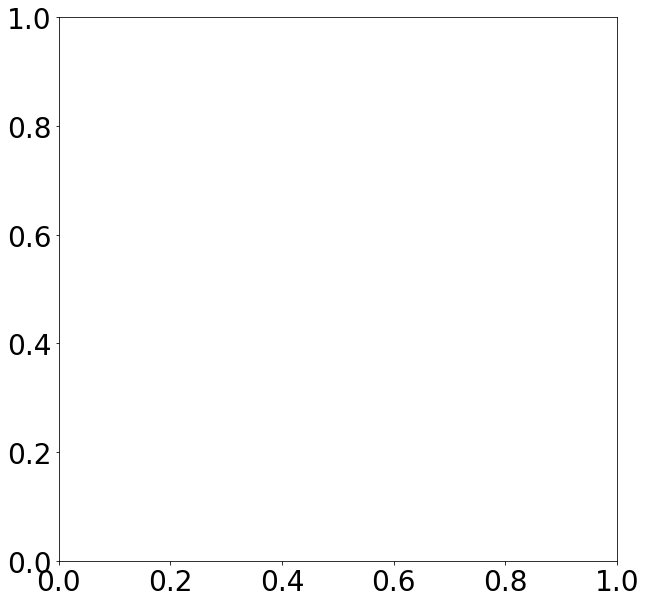

In [42]:
# Change ALL to OPEN to get different results
scaler = ALL_scaler
scomplex = ALL_scomplex
X_scaled = ALL_Xscaled
df = ALL_X

state_dict = {'cube834_cluster0':'1','cube671_cluster0':'2','cube60_cluster0':'3'}

# Important that variables are in this order
variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

plot_vars = ["TURB","VEL","DO"]

for var in plot_vars:
    # Get the boxplots of this var for each state
    var_df = pd.DataFrame(np.full((70830,3),None),columns=['1','2','3'])
    for state in scomplex['states']:
        df = getSubdf(scomplex,scomplex['states'][state],X_scaled)
        df.columns = variables
        #print(df[var])
        var_df[state_dict[state]] = df[var]
        #print(df[var])
        display(var_df)
        
        
    #display(var_df)
    print(var_df.shape)
    ax = var_df.boxplot(column=['1','2','3'],return_type='axes',figsize=(10,10),fontsize=28)
    ax.set_ylim(bottom=-2.4,top=8.8)
    ax.figure.savefig("Entire Data robust"+var)
    plt.cla()
    
        
        

# for state in scomplex['states']:
#     df = getSubdf(scomplex, scomplex['states'][state], X_scaled)
    
#     df.columns = variables
    
#     plot_vars = ["TURB","VEL","DO","SS"]
    
#     #df_orig = scaler.inverse_transform(df)
#     #df_minmax = pd.DataFrame(MinMaxScaler().fit_transform(df_orig),columns=variables)
    
#     # Make a boxplot of the df
#     ax = df.boxplot(column=plot_vars,return_type='axes',figsize=(10,10),fontsize=28,rot=45)
#     ax.set_ylim(bottom=-2.4,top=8.8)
    
#     #ax.figure.savefig("Entire Data robust"+str(df.shape[0]))
#     plt.cla()

In [15]:
pd.DataFrame(columns=plot_vars,index=[1,2,3])

,TURB,VEL,DO,SS
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN


In [317]:
for state in scomplex['states']:
    print(state)

cube834_cluster0
cube671_cluster0
cube60_cluster0


In [21]:
# Change ALL to OPEN to get different results
scaler = OPEN_scaler
scomplex = OPEN_scomplex
X_scaled = OPEN_Xscaled
df = OPEN_X


variables = ['TN', 'TP', 'TEMP', 'DO', 'TURB', 'VEL', 'SS', 'WDP', 'CHLcal', 'SECCHI']

# Robust keys is list of state maximas
list_states = list(scomplex['states'].keys())
for var in variables:
    for state1 in list_states:
        pvals = []
        state1Df = getSubdf(scomplex, scomplex['states'][state1], df)
        for state2 in list_states:
            
            if state1 == state2:
                continue
            state2Df = getSubdf(scomplex, scomplex['states'][state2], df)
            print("var: ", var, "| state1: ", state1, ", datapoints: ", state1Df.shape[0], 
                  "| state2:", state2, ", datatpoints: ", state2Df.shape[0] )
            sample1 = state1Df[var]
            sample2 = state2Df[var]
            pvals.append(stats.ttest_ind(sample1, sample2, equal_var=False).pvalue)
            print("Sample means: ", sample1.mean(), " | ", sample2.mean())
            #print(stats.ttest_ind(sample1, sample2, equal_var=False))
        if False in multitest.multipletests(pvals, method = 'bonferroni')[0]:# 0 for reject nulls, 1 for adjusted p vals
            print(multitest.multipletests(pvals, method = 'bonferroni')[0])
        else:
            print("They are all different")
          
        print("---------")

var:  TN | state1:  cube192_cluster0 , datapoints:  69 | state2: cube105_cluster0 , datatpoints:  845
Sample means:  3.102521739130435  |  3.760671005917157
var:  TN | state1:  cube192_cluster0 , datapoints:  69 | state2: cube80_cluster0 , datatpoints:  4394
Sample means:  3.102521739130435  |  2.493036185707782
var:  TN | state1:  cube192_cluster0 , datapoints:  69 | state2: cube52_cluster0 , datatpoints:  1789
Sample means:  3.102521739130435  |  3.447707098937955
var:  TN | state1:  cube192_cluster0 , datapoints:  69 | state2: cube110_cluster0 , datatpoints:  5375
Sample means:  3.102521739130435  |  3.1423464186046433
[ True  True  True False]
---------
var:  TN | state1:  cube105_cluster0 , datapoints:  845 | state2: cube192_cluster0 , datatpoints:  69
Sample means:  3.760671005917157  |  3.102521739130435
var:  TN | state1:  cube105_cluster0 , datapoints:  845 | state2: cube80_cluster0 , datatpoints:  4394
Sample means:  3.760671005917157  |  2.493036185707782
var:  TN | state1: 